In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt


In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    计算两点间的地理距离。
    参数:
    - lon1, lat1: 第一个点的经度和纬度
    - lon2, lat2: 第二个点的经度和纬度
    返回值:
    - 地理距离（公里）
    """
    # 将十进制度数转换为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # 哈弗西公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位公里
    return c * r

In [4]:
# Load the Excel file
file_path = 'Rental_Fully_Processed_For_RandomForest.xlsx'
#file_path = 'Rental_Fully_Prepared_For_LSTM.xlsx'
data = pd.read_excel(file_path)
#print('data.info', data.info())
print(data.head())


   Price  Area  Floor  Total_floor  Orientation   Longitude   Latitude  \
0   6000    86      7           10          100  114.170805  22.567821   
1   4600    67     13           18            1  114.178740  22.564981   
2   4800    74     12           16          101  114.175443  22.563772   
3   6800    78     15           31          101  114.133740  22.547596   
4   6500    78      7           31          100  114.126312  22.543263   

   Elevators  Water  Electricity  ...  Community name  Lease method  Room  \
0          1      1            1  ...            2485             1     3   
1          1      1            1  ...             638             1     2   
2          1      1            1  ...            2486             1     3   
3          1      1            1  ...            2296             1     3   
4          1      1            1  ...             346             1     2   

   Hall  Toilet  Availability  Showings time  Listing Year  Listing Month  \
0     1       1

In [27]:
# Remove latitude and longitude
######data = data.drop(['Longitude', 'Latitude'], axis=1)
data['Floor_ratio'] = data['Floor'] / data['Total_floor']
data['Area_per_Room'] = data['Area'] / data['Room']
data['Elevator_Access'] = data['Elevators'] * data['Floor_ratio']
# 计算距离特征
data['Distance_to_SZCenter'] = data.apply(
    lambda row: haversine(114.05956, 22.54399, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_LuohuCenter'] = data.apply(
    lambda row: haversine(114.1178, 22.5450, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_NanshanTechPark'] = data.apply(
    lambda row: haversine(113.95377, 22.53467, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_BaoanCenter'] = data.apply(
    lambda row: haversine(113.88308, 22.55329, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_GuangmingCenter'] = data.apply(
    lambda row: haversine(113.93577, 22.74892, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_LonggangCenter'] = data.apply(
    lambda row: haversine(114.24779, 22.71991, row['Longitude'], row['Latitude']),
    axis=1
)
data['Distance_to_YantianCenter'] = data.apply(
    lambda row: haversine(114.23670, 22.55641, row['Longitude'], row['Latitude']),
    axis=1
)

# 特征列表
features = [
    'Area','Floor', 'Total_floor', 'Orientation', 'Longitude', 'Latitude', 'Elevators', 'Electricity', 
    'Area_per_Room', 'Elevator_Access', 'Distance_to_SZCenter',
    'Distance_to_LuohuCenter', 'Distance_to_NanshanTechPark', 'Distance_to_BaoanCenter','Distance_to_LonggangCenter',
    'Distance_to_GuangmingCenter', 
    'First area', 'Second area', 'Hall', 'Toilet', 'Availability', 'Showings time', 'Listing Year'
]

In [6]:
# Separate features and target variable
X = data[features]
#y = data['Price']
y = np.log1p(data['Price'])



In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [8]:
# Define a function to optimize
def xgb_evaluate(max_depth, learning_rate, n_estimators, colsample_bytree, alpha):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'colsample_bytree': colsample_bytree,
        'alpha': alpha
    }
    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return np.mean(scores)  # Bayesian optimization always tries to maximize the function

# Setup the bounds for the parameters
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (100, 1000),
    'colsample_bytree': (0.3, 0.7),
    'alpha': (1, 10)
}

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Perform Bayesian Optimization
optimizer.maximize(
    init_points=10,
    n_iter=25,
)

# Extract the best parameters
best_params = optimizer.max['params']

# Format the parameters for XGB
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])


|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.002498 | 4.371     | 0.6803    | 0.07588   | 7.191     | 240.4     |
| 2         | -0.00333  | 2.404     | 0.3232    | 0.08796   | 7.208     | 737.3     |
| 3         | -0.001445 | 1.185     | 0.688     | 0.08492   | 4.486     | 263.6     |
| 4         | -0.003524 | 2.651     | 0.4217    | 0.05723   | 6.024     | 362.1     |
| 5         | -0.006176 | 6.507     | 0.3558    | 0.03629   | 5.565     | 510.5     |
| 6         | -0.009487 | 8.067     | 0.3799    | 0.05628   | 7.147     | 141.8     |
| 7         | -0.006657 | 6.468     | 0.3682    | 0.01585   | 9.642     | 969.1     |
| 8         | -0.007375 | 8.276     | 0.4218    | 0.01879   | 7.79      | 496.1     |
| 9         | -0.008246 | 2.098     | 0.4981    | 0.01309   | 9.365     | 332.9     |
| 10        | -0.005578 | 6.963     | 0.4247    | 0.05

In [9]:
# Train the model with the best parameters
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)



XGBRegressor(alpha=2.1651235566813645, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6760926693432123, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04907118525946302, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=628, n_jobs=None,
             num_parallel_tree=None, ...)

In [10]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)  # 将预测结果反对数变换回原始尺度
y_test = np.expm1(y_test)



In [11]:
# Create a DataFrame with predictions and actual values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df)

        Actual     Predicted
8546    5000.0   5193.095703
5250   18000.0  17809.837891
6315    4500.0   4522.372559
16094   3390.0   3523.072998
10643   4500.0   4394.296875
...        ...           ...
3328   11000.0  11121.344727
15032   5500.0   5526.530762
10384   5000.0   4925.636719
5758    2100.0   2097.565430
367    10600.0  11651.305664

[5583 rows x 2 columns]


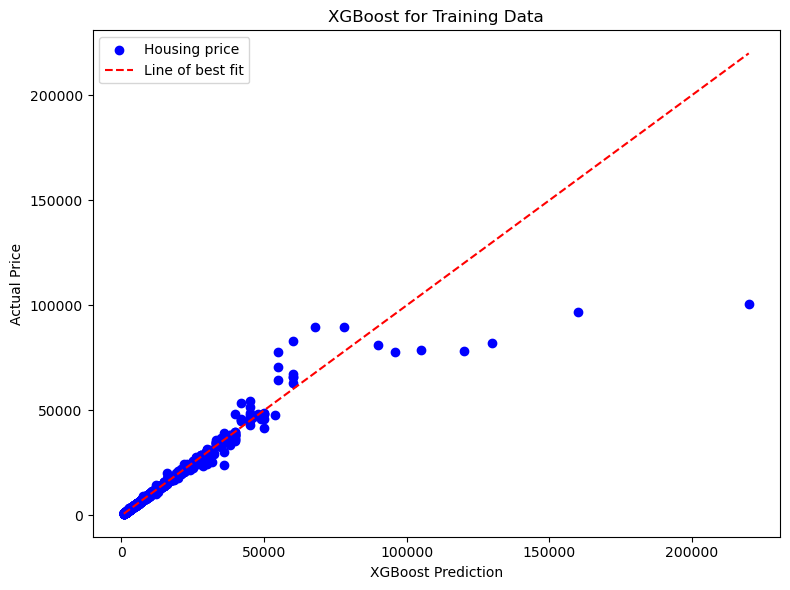

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图形大小
ax.scatter(y_test, y_pred, color='blue', label='Housing price')  # 实际房价 vs 预测房价
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Line of best fit')  # 绘制最佳拟合线
ax.set_title('XGBoost for Training Data')  # 图形标题
ax.set_xlabel('XGBoost Prediction')  # x轴标签
ax.set_ylabel('Actual Price')  # y轴标签
ax.legend()  # 显示图例
plt.tight_layout()  # 自动调整子图参数以适应图形区域
plt.show()  # 显示图形

In [13]:
# Custom evaluation metrics
def calculate_custom_metrics(y_true, y_pred, tolerance=0.1):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rmlse = np.sqrt(mean_squared_log_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    accuracy_01 = np.mean(np.abs(y_true - y_pred) <= tolerance * np.max(y_true))
    average_error_rate = np.mean(np.abs(y_true - y_pred) / y_true)
    average_accuracy = 1 - average_error_rate

    return mse, rmse, rmlse, r2, accuracy_01, average_error_rate, average_accuracy

# Calculate the custom metrics
mse, rmse, rmlse, r2, accuracy_01, average_error_rate, average_accuracy = calculate_custom_metrics(y_test, y_pred, tolerance=0.1)

# Print custom evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"RMLSE: {rmlse}")
print(f"R Square: {r2}")
print(f"Accuracy (tolerance=0.1): {accuracy_01}")
print(f"Average Error Rate: {average_error_rate}")
print(f"Average Accuracy: {average_accuracy}")

MSE: 4807677.622334237
RMSE: 2192.6416994881397
RMLSE: 0.03263918847979845
R Square: 0.9324925777346643
Accuracy (tolerance=0.1): 0.9987461938026151
Average Error Rate: 0.017011543727547523
Average Accuracy: 0.9829884562724525


In [36]:
# 生成特征重要性
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)




Feature Importance:
                        Feature  Importance
0                          Area    0.300809
8                 Area_per_Room    0.143366
19                       Toilet    0.079575
6                     Elevators    0.070712
5                      Latitude    0.060295
21                Showings time    0.046198
18                         Hall    0.037558
12  Distance_to_NanshanTechPark    0.036003
14   Distance_to_LonggangCenter    0.032886
16                   First area    0.027780
2                   Total_floor    0.027621
9               Elevator_Access    0.025837
10         Distance_to_SZCenter    0.018558
13      Distance_to_BaoanCenter    0.015783
11      Distance_to_LuohuCenter    0.013134
3                   Orientation    0.012171
4                     Longitude    0.011731
17                  Second area    0.011690
15  Distance_to_GuangmingCenter    0.008906
22                 Listing Year    0.006149
7                   Electricity    0.006139
1          

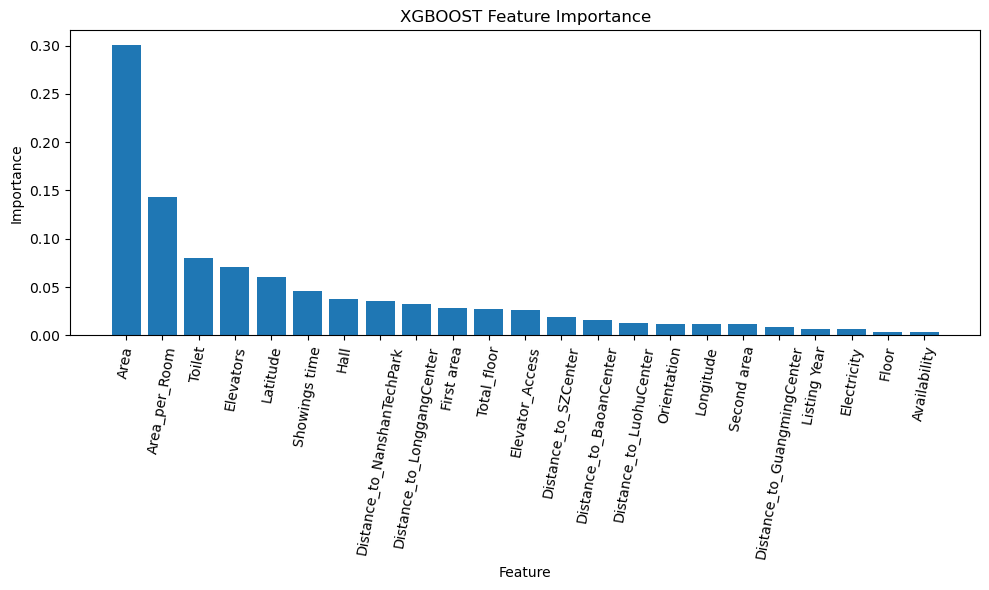

In [37]:
# 绘制特征重要性柱状图
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=80)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGBOOST Feature Importance')
plt.tight_layout()
plt.show()